<a href="https://colab.research.google.com/github/c7blackjack/ADS508/blob/main/ADS508_Group5_Final%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Install all required packages before running notebook.
##Remember to restart the kernel after installing packages.

#!pip install boto
#!pip install sagemaker
#!pip install xgboost
#!pip install awscli

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
import boto3.session
import sagemaker
import os
import xgboost as xgb

In [3]:
#!aws configure

AWS Access Key ID [****************VJ5D]: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/awscli/clidriver.py", line 218, in main
    return command_table[parsed_args.command](remaining, parsed_args)
  File "/usr/local/lib/python3.7/dist-packages/awscli/customizations/commands.py", line 187, in __call__
    return self._run_main(parsed_args, parsed_globals)
  File "/usr/local/lib/python3.7/dist-packages/awscli/customizations/configure/configure.py", line 109, in _run_main
    prompt_text)
  File "/usr/local/lib/python3.7/dist-packages/awscli/customizations/configure/configure.py", line 42, in get_value
    response = compat_input("%s [%s]: " % (prompt_text, current_value))
  File "/usr/local/lib/python3.7/dist-packages/awscli/compat.py", line 232, in compat_input
    return raw_input()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/aws", line 27, in <modu

In [4]:
!aws s3 ls s3://ads508bucket2

                           PRE AutoMLJob-MentalHealth/
                           PRE InitialRun/
2022-03-28 07:17:12     825534 cyouth_demo_age_20210328.csv
2022-03-28 07:17:12    1118781 cyouth_demo_race_20210328.csv
2022-03-28 07:17:12     310455 cyouth_demo_sex_20210328.csv
2022-03-28 07:17:13   25070533 cyouth_util_age_20210328.csv
2022-04-05 06:34:35   22935956 df2.csv


In [5]:
sess = boto3.Session(region_name='us-east-1')

In [6]:
client = boto3.client('s3')

In [7]:
resp = client.list_buckets()
resp

{'Buckets': [{'CreationDate': datetime.datetime(2022, 3, 28, 7, 16, 14, tzinfo=tzlocal()),
   'Name': 'ads508bucket2'},
  {'CreationDate': datetime.datetime(2022, 3, 21, 6, 36, 6, tzinfo=tzlocal()),
   'Name': 'ads508teamproject'},
  {'CreationDate': datetime.datetime(2022, 3, 28, 4, 35, 5, tzinfo=tzlocal()),
   'Name': 'sagemaker-studio-8a5of8v5prl'},
  {'CreationDate': datetime.datetime(2022, 4, 5, 18, 46, 44, tzinfo=tzlocal()),
   'Name': 'sagemaker-us-east-2-454861626188'}],
 'Owner': {'ID': '48f14138b8ccbbc0993dd4b3360b951bc781c4f97d5ca71230c87d4a1d8c4443'},
 'ResponseMetadata': {'HTTPHeaders': {'content-type': 'application/xml',
   'date': 'Tue, 12 Apr 2022 05:52:42 GMT',
   'server': 'AmazonS3',
   'transfer-encoding': 'chunked',
   'x-amz-id-2': 'j7ZFgY9WTHHRg3CYITDx455icY3UD4vHZlOVcmDqefqp4AFX45+odU6839Dq0GWc9g6OCl8M2zc=',
   'x-amz-request-id': 'HWVE24A62PRWD0TM'},
  'HTTPStatusCode': 200,
  'HostId': 'j7ZFgY9WTHHRg3CYITDx455icY3UD4vHZlOVcmDqefqp4AFX45+odU6839Dq0GWc9g6OCl8M2z

In [8]:
s3 = boto3.resource('s3')

In [9]:
list(s3.buckets.all())

[s3.Bucket(name='ads508bucket2'),
 s3.Bucket(name='ads508teamproject'),
 s3.Bucket(name='sagemaker-studio-8a5of8v5prl'),
 s3.Bucket(name='sagemaker-us-east-2-454861626188')]

In [10]:
bucket = s3.Bucket('ads508teamproject')

In [11]:
files = list(bucket.objects.all())

In [12]:
for file in files:
    client.download_file('ads508teamproject', file.key, file.key)

In [54]:
age = pd.read_csv(files[0].key)
demo = pd.read_csv(files[1].key)
sex = pd.read_csv(files[2].key)
util = pd.read_csv(files[3].key)
df = pd.read_csv(files[4].key)
merged = pd.read_csv(files[5].key)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
df.head()

,Unnamed: 0,FISCAL_YEAR,POPULATION_NAME,MHS_TYPE,GROUP_NAME,GROUP_TOTAL,GROUP_GRAND_TOTAL,GRP_PCT_BY_YEAR_MHS
0,0,2017,Alameda,MHS,A1 Children 0-2,26932.0,541857,0.04970
1,1,2017,Alameda,MHS,A2 Children 3-5,26641.0,541857,0.04917
2,2,2017,Alameda,MHS,A3 Children 6-11,54276.0,541857,0.10017
3,3,2017,Alameda,MHS,A4 Children 12-17,50334.0,541857,0.09289
4,4,2017,Alameda,MHS,A5 Youth 18-20,22436.0,541857,0.04141


In [15]:
df.columns

Index(['Unnamed: 0', 'FISCAL_YEAR', 'POPULATION_NAME', 'MHS_TYPE',
       'GROUP_NAME', 'GROUP_TOTAL', 'GROUP_GRAND_TOTAL',
       'GRP_PCT_BY_YEAR_MHS'],
      dtype='object')

In [16]:
df.drop(['Unnamed: 0'],axis=1, inplace=True)


In [17]:
df['GROUP_NAME'].replace(' ', '_', regex=True, inplace=True)

In [18]:
df.head()

,FISCAL_YEAR,POPULATION_NAME,MHS_TYPE,GROUP_NAME,GROUP_TOTAL,GROUP_GRAND_TOTAL,GRP_PCT_BY_YEAR_MHS
0,2017,Alameda,MHS,A1_Children_0-2,26932.0,541857,0.04970
1,2017,Alameda,MHS,A2_Children_3-5,26641.0,541857,0.04917
2,2017,Alameda,MHS,A3_Children_6-11,54276.0,541857,0.10017
3,2017,Alameda,MHS,A4_Children_12-17,50334.0,541857,0.09289
4,2017,Alameda,MHS,A5_Youth_18-20,22436.0,541857,0.04141


In [19]:
df.dtypes

FISCAL_YEAR              int64
POPULATION_NAME         object
MHS_TYPE                object
GROUP_NAME              object
GROUP_TOTAL            float64
GROUP_GRAND_TOTAL        int64
GRP_PCT_BY_YEAR_MHS    float64
dtype: object

In [20]:
#Code used before implementation of S3 Bucket via AWS Services

"""
url1 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/9b4b7b99-96de-4cca-b8ad-992f38f60697/download/cyouth_util_age_20210328.csv"
url2 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/1b8821d7-cd56-4fcf-8b15-3cf5d66bdba7/download/cyouth_demo_race_20210328.csv"
url3 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/80447662-f12e-44f7-a31c-5768e6917f2e/download/cyouth_dx_age_20210328.csv"

util = pd.read_csv(url1)
demo = pd.read_csv(url2)
age  = pd.read_csv(url3)
"""

'\nurl1 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/9b4b7b99-96de-4cca-b8ad-992f38f60697/download/cyouth_util_age_20210328.csv"\nurl2 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/1b8821d7-cd56-4fcf-8b15-3cf5d66bdba7/download/cyouth_demo_race_20210328.csv"\nurl3 = "https://data.chhs.ca.gov/dataset/8eb607d8-5876-4ee0-a681-c6a03cee4de5/resource/80447662-f12e-44f7-a31c-5768e6917f2e/download/cyouth_dx_age_20210328.csv"\n\nutil = pd.read_csv(url1)\ndemo = pd.read_csv(url2)\nage  = pd.read_csv(url3)\n'

In [21]:
util.head(3)

,POPULATION_NAME,POPULATION_TYPE,FISCAL_YEAR,AGE_GRP,SVC_DESC,UNIT_TYPE,AMOUNT,AMOUNT_ANNOT,MHS_TYPE
0,Alameda,01,2017,A1 Children 0-2,ACTIVITY_THERAPY,BENE_COUNT,NaN,1.0,MHS
1,Alameda,01,2017,A1 Children 0-2,ACTIVITY_THERAPY,TOTAL_MINUTES,NaN,2.0,MHS
2,Alameda,01,2017,A1 Children 0-2,ADAPT_BHV_TX-QHP,BENE_COUNT,19.0,NaN,MHS


In [22]:
pd.crosstab(util.AGE_GRP, util.UNIT_TYPE)
# Perhaps TOTAL_DAYS is the value keep, to represent UNIT_TYPE?

UNIT_TYPE,BENE_COUNT,TOTAL_DAYS,TOTAL_DOLLARS,TOTAL_HOURS,TOTAL_MINUTES,TOTAL_UNITS
AGE_GRP,,,,,,
A1 Children 0-2,13622,4,653,824,7020,4276
A2 Children 3-5,21236,113,847,1614,12064,5803
A3 Children 6-11,29660,866,891,2655,17122,7349
A4 Children 12-17,33255,1736,892,3250,18486,8108
A5 Youth 18-20,27814,2381,871,2496,14925,6307


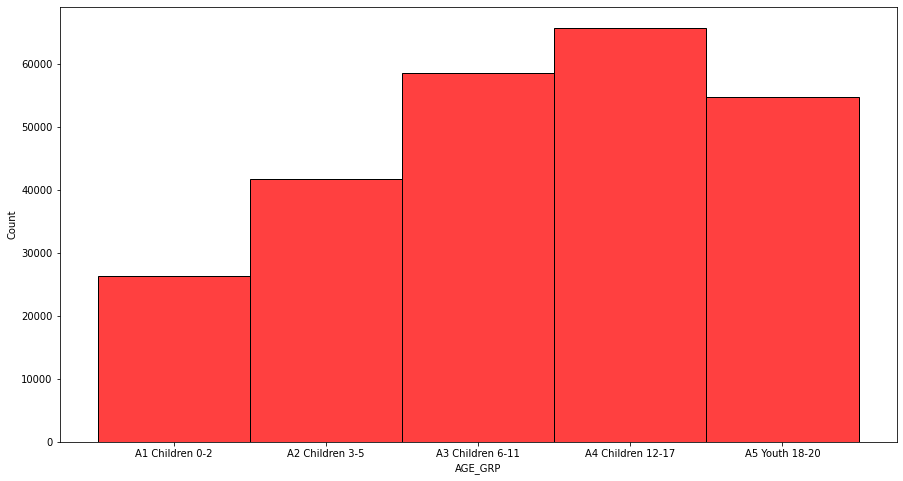

In [23]:
plt.figure(figsize=(15,8))

sns.histplot(data=util, x="AGE_GRP", color="red")#, kde=True)
#sns.histplot(data=util, x="MHS_TYPE", color="blue")#, kde=True)

plt.show()

# Patients ages 12 to 17 require the bulk of care, as compared to other age groups in the dataset.

In [24]:
pd.crosstab(util.AGE_GRP, util.MHS_TYPE)
# There are a lot more patients being treated under "MHS" instead of "SMHS"

# We can split the dataset, one set per MHS_TYPE, or combine the two, but balance the data so that
# it is not biased towards MHS, which contains the majority of the records.

MHS_TYPE,MHS,SMHS
AGE_GRP,,
A1 Children 0-2,21581,4818
A2 Children 3-5,31713,9964
A3 Children 6-11,43269,15274
A4 Children 12-17,47205,18522
A5 Youth 18-20,36946,17848


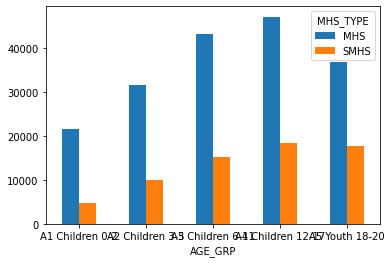

In [25]:
age_mhstype_crosstb = pd.crosstab(util.AGE_GRP, util.MHS_TYPE)
age_mhstype_crosstb.plot.bar(rot=0)
# Visual representation of MHS_TYPE = "MHS" having the majority of patients.
# The trends between MHS_TYPE amongst the AGE_GRP appear similar, except for the
# last two AGE_GRP, where SMHS is very similar between groups 12-17 and 18-20. 

In [26]:
age_time_group = pd.crosstab(util.AGE_GRP, util.FISCAL_YEAR)
age_time_group
# All groups show an increase; however, there is a decrease in the last year of the dataset, 2020,
# perhaps due to the pandemic.

FISCAL_YEAR,2017,2018,2019,2020
AGE_GRP,,,,
A1 Children 0-2,6193,6509,6953,6744
A2 Children 3-5,9976,10173,11120,10408
A3 Children 6-11,14059,14277,15516,14691
A4 Children 12-17,15380,16144,17491,16712
A5 Youth 18-20,12819,13586,14379,14010


<Figure size 936x432 with 0 Axes>

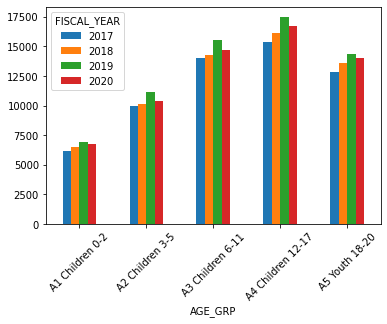

In [27]:
plt.figure(figsize=(13,6))
age_time_group.plot.bar(rot=45)

In [28]:
demo.head()

,POPULATION_NAME,POPULATION_TYPE,FISCAL_YEAR,RACE_GRP,TOTAL_CT,TOTAL_CT_ANNOT,MHS1_CT,MHS1_CT_ANNOT,MHS5_CT,MHS5_CT_ANNOT,MHS_TYPE
0,Alameda,01,2017,R1 Alaskan Native or American Indian,392.0,NaN,26.0,NaN,NaN,1.0,MHS
1,Alameda,01,2017,R2 Asian or Pacific Islander,31643.0,NaN,1366.0,NaN,256.0,NaN,MHS
2,Alameda,01,2017,R3 Black,31057.0,NaN,2299.0,NaN,332.0,NaN,MHS
3,Alameda,01,2017,R4 Hispanic,73605.0,NaN,4964.0,NaN,835.0,NaN,MHS
4,Alameda,01,2017,R5 White,13401.0,NaN,1267.0,NaN,326.0,NaN,MHS


In [29]:
demo_group = demo.groupby(['FISCAL_YEAR','RACE_GRP'])['TOTAL_CT'].sum()
demo_group

FISCAL_YEAR  RACE_GRP                            
2017         R1 Alaskan Native or American Indian      168432.0
             R2 Asian or Pacific Islander             3492246.0
             R3 Black                                 3452816.0
             R4 Hispanic                             29310256.0
             R5 White                                 7257112.0
             R6 Other                                 2502710.0
             R7 Unknown                               4293155.0
2018         R1 Alaskan Native or American Indian      161500.0
             R2 Asian or Pacific Islander             3241876.0
             R3 Black                                 3342461.0
             R4 Hispanic                             28594676.0
             R5 White                                 6876618.0
             R6 Other                                 2646802.0
             R7 Unknown                               4117084.0
2019         R1 Alaskan Native or American Indian     

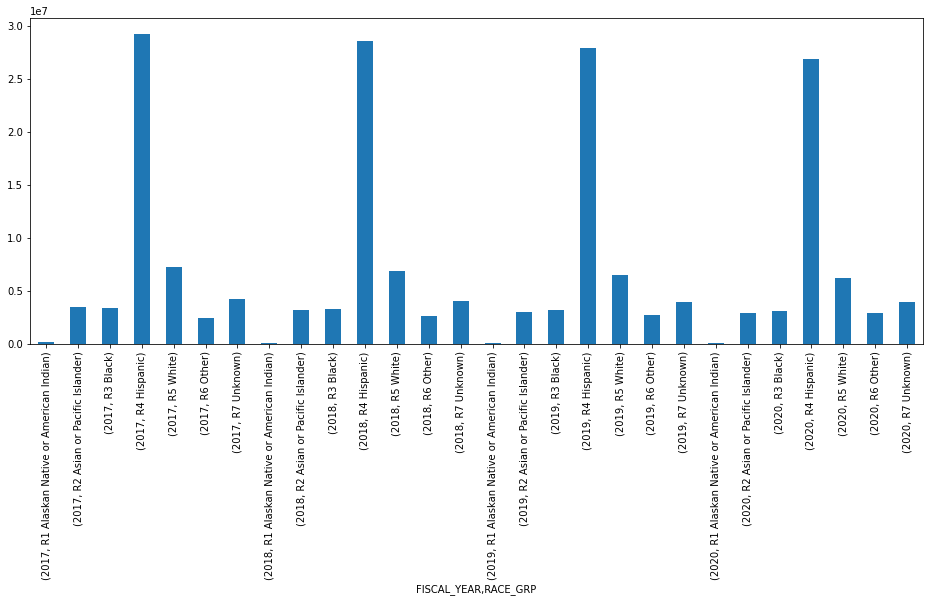

In [30]:
demo_group.plot.bar(rot=90,figsize=(16,6))


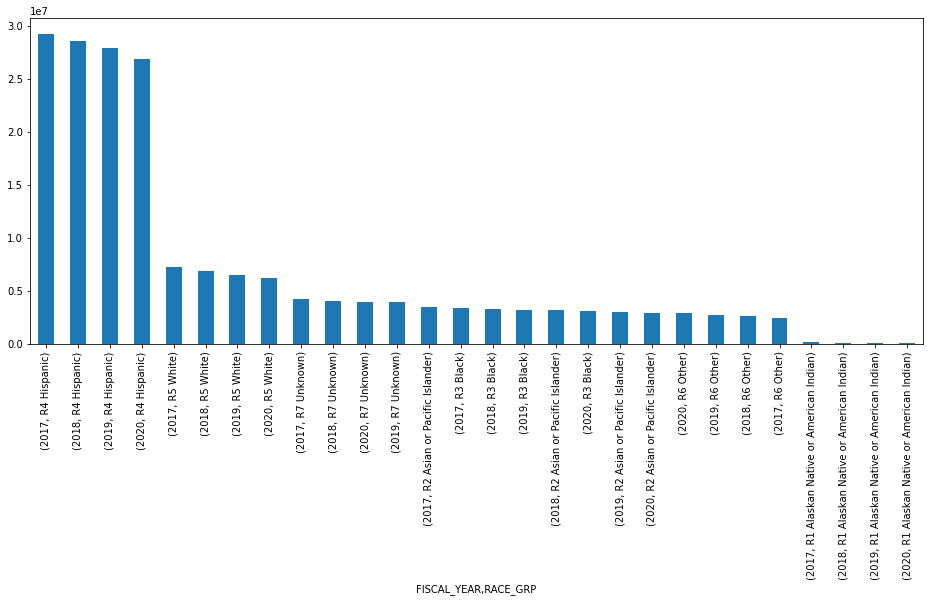

In [31]:
dg_sorted = demo_group.sort_values(ascending=False)
dg_sorted
dg_sorted.plot.bar(rot=90,figsize=(16,6))


In [32]:
age.head(30)

,POPULATION_NAME,POPULATION_TYPE,FISCAL_YEAR,AGE_GRP,TOTAL_CT,TOTAL_CT_ANNOT,MHS1_CT,MHS1_CT_ANNOT,MHS5_CT,MHS5_CT_ANNOT,MHS_TYPE
0,Alameda,01,2017,A1 Children 0-2,26932.0,NaN,2026.0,NaN,44.0,NaN,MHS
1,Alameda,01,2017,A2 Children 3-5,26641.0,NaN,1120.0,NaN,255.0,NaN,MHS
2,Alameda,01,2017,A3 Children 6-11,54276.0,NaN,3442.0,NaN,790.0,NaN,MHS
3,Alameda,01,2017,A4 Children 12-17,50334.0,NaN,4119.0,NaN,840.0,NaN,MHS
4,Alameda,01,2017,A5 Youth 18-20,22436.0,NaN,1417.0,NaN,249.0,NaN,MHS
5,Alameda,01,2018,A1 Children 0-2,25153.0,NaN,2195.0,NaN,50.0,NaN,MHS
6,Alameda,01,2018,A2 Children 3-5,25471.0,NaN,1402.0,NaN,331.0,NaN,MHS
7,Alameda,01,2018,A3 Children 6-11,52088.0,NaN,3907.0,NaN,921.0,NaN,MHS
8,Alameda,01,2018,A4 Children 12-17,49294.0,NaN,4946.0,NaN,1033.0,NaN,MHS
9,Alameda,01,2018,A5 Youth 18-20,22515.0,NaN,1781.0,NaN,337.0,NaN,MHS


In [33]:
df_age = age.groupby(['AGE_GRP','MHS_TYPE'],as_index=False)['TOTAL_CT'].sum()
df_age


,AGE_GRP,MHS_TYPE,TOTAL_CT
0,A1 Children 0-2,MHS,13995636.0
1,A1 Children 0-2,SMHS,13993664.0
2,A2 Children 3-5,MHS,14152638.0
3,A2 Children 3-5,SMHS,14150494.0
4,A3 Children 6-11,MHS,28883636.0
5,A3 Children 6-11,SMHS,28877784.0
6,A4 Children 12-17,MHS,27804764.0
7,A4 Children 12-17,SMHS,27774138.0
8,A5 Youth 18-20,MHS,12043406.0
9,A5 Youth 18-20,SMHS,11969395.0


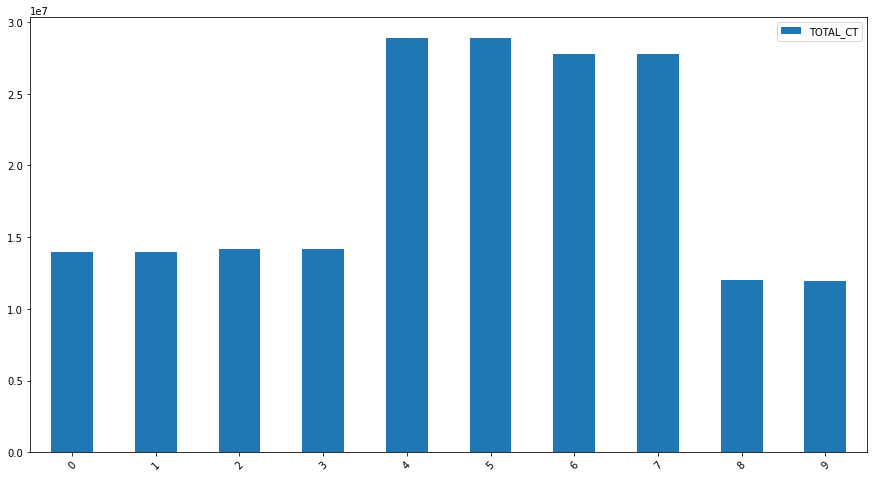

In [34]:
df_age.plot.bar(rot=45,figsize=(15,8))

In [35]:
df_age_diff = df_age.groupby(['AGE_GRP'])['TOTAL_CT'].diff().dropna()
#df_age['COUNT_DIFF'] = df_age_diff
df_age_diff = df_age_diff.abs()

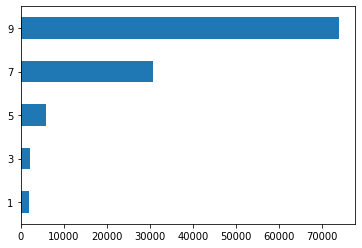

In [36]:
df_age_diff.plot.barh()

Similarities between sets...
- FISCAL_YEAR
- MHS_TYPE


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics._plot.confusion_matrix import plot_confusion_matrix


In [56]:
df2 = df

In [57]:
df2.head()

,Unnamed: 0,FISCAL_YEAR,POPULATION_NAME,MHS_TYPE,GROUP_NAME,GROUP_TOTAL,GROUP_GRAND_TOTAL,GRP_PCT_BY_YEAR_MHS
0,0,2017,Alameda,MHS,A1 Children 0-2,26932.0,541857,0.04970
1,1,2017,Alameda,MHS,A2 Children 3-5,26641.0,541857,0.04917
2,2,2017,Alameda,MHS,A3 Children 6-11,54276.0,541857,0.10017
3,3,2017,Alameda,MHS,A4 Children 12-17,50334.0,541857,0.09289
4,4,2017,Alameda,MHS,A5 Youth 18-20,22436.0,541857,0.04141


In [58]:
df2.dtypes

Unnamed: 0               int64
FISCAL_YEAR              int64
POPULATION_NAME         object
MHS_TYPE                object
GROUP_NAME              object
GROUP_TOTAL            float64
GROUP_GRAND_TOTAL        int64
GRP_PCT_BY_YEAR_MHS    float64
dtype: object

In [59]:
df2.columns

Index(['Unnamed: 0', 'FISCAL_YEAR', 'POPULATION_NAME', 'MHS_TYPE',
       'GROUP_NAME', 'GROUP_TOTAL', 'GROUP_GRAND_TOTAL',
       'GRP_PCT_BY_YEAR_MHS'],
      dtype='object')

In [60]:
columns = ['FISCAL_YEAR', 'POPULATION_NAME',
       'GROUP_NAME', 'GROUP_TOTAL', 'GROUP_GRAND_TOTAL','GRP_PCT_BY_YEAR_MHS']

In [98]:
y = df2['MHS_TYPE']
X = df2[columns]

In [99]:
len(y.index)

375956

In [100]:
X_encoded = pd.get_dummies(X, columns=['FISCAL_YEAR',	'POPULATION_NAME',	'GROUP_NAME'])
X_encoded.head()

,GROUP_TOTAL,GROUP_GRAND_TOTAL,GRP_PCT_BY_YEAR_MHS,FISCAL_YEAR_2017,FISCAL_YEAR_2018,FISCAL_YEAR_2019,FISCAL_YEAR_2020,POPULATION_NAME_Alameda,POPULATION_NAME_Alpine,POPULATION_NAME_Amador,...,GROUP_NAME_A5 Youth 18-20,GROUP_NAME_R1 Alaskan Native or American Indian,GROUP_NAME_R2 Asian or Pacific Islander,GROUP_NAME_R3 Black,GROUP_NAME_R4 Hispanic,GROUP_NAME_R5 White,GROUP_NAME_R6 Other,GROUP_NAME_R7 Unknown,GROUP_NAME_S1 Female,GROUP_NAME_S2 Male
0,26932.0,541857,0.04970,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26641.0,541857,0.04917,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,54276.0,541857,0.10017,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50334.0,541857,0.09289,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,22436.0,541857,0.04141,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0


In [101]:
len(X_encoded.index)

375956

In [105]:
y_encoded = pd.get_dummies(y, columns=['MHS_TYPE'])
len(y_encoded.index)

375956

In [106]:
y_encoded.drop('SMHS',axis = 1, inplace=True)


In [107]:
y_encoded = y_encoded.rename(columns={"MHS": "MHS_TYPE"})

y_encoded.head(10)

,MHS_TYPE
0,1
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y_encoded,random_state = 40, test_size=0.20)

In [118]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                            reg_alpha=0.995117,
                            max_depth=8,
                            reg_lambda=1.836912,
                            gamma=0.000233,
                            min_child_weight=0.000222,
                            colsample_bytree=0.855253,
                            seed=40,missing=None)

In [119]:
clf_xgb.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,eval_metric='aucpr',eval_set=[(X_test,y_test)])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-aucpr:0.529746
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.529746
[2]	validation_0-aucpr:0.529746
[3]	validation_0-aucpr:0.531546
[4]	validation_0-aucpr:0.531546
[5]	validation_0-aucpr:0.531546
[6]	validation_0-aucpr:0.531546
[7]	validation_0-aucpr:0.53774
[8]	validation_0-aucpr:0.53774
[9]	validation_0-aucpr:0.53774
[10]	validation_0-aucpr:0.53774
[11]	validation_0-aucpr:0.579666
[12]	validation_0-aucpr:0.579666
[13]	validation_0-aucpr:0.589355
[14]	validation_0-aucpr:0.589355
[15]	validation_0-aucpr:0.589355
[16]	validation_0-aucpr:0.589355
[17]	validation_0-aucpr:0.589355
[18]	validation_0-aucpr:0.589355
[19]	validation_0-aucpr:0.589355
[20]	validation_0-aucpr:0.589355
[21]	validation_0-aucpr:0.589355
[22]	validation_0-aucpr:0.593773
[23]	validation_0-aucpr:0.593773
[24]	validation_0-aucpr:0.583057
[25]	validation_0-aucpr:0.583057
[26]	validation_0-aucpr:0.583057
[27]	validation_0-aucpr:0.583057
[28]	validation_0-aucpr:

XGBClassifier(colsample_bytree=0.855253, gamma=0.000233, max_depth=8,
              min_child_weight=0.000222, reg_alpha=0.995117,
              reg_lambda=1.836912, seed=40)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


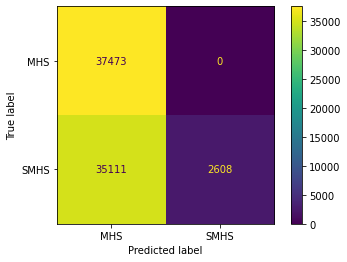

In [122]:
plot_confusion_matrix(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=['MHS','SMHS'])

In [117]:
plot_confusion_matrix